<a href="https://colab.research.google.com/github/hollyisyoon/TIL/blob/main/%ED%9B%88%EC%98%81_ab%ED%85%8C%EC%8A%A4%ED%8A%B8_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import math as mt
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats

In [11]:
control = pd.read_csv('https://raw.githubusercontent.com/baumanab/udacity_ABTesting/master/data/Final%20Project%20Results%20-%20Control.csv')
exp = pd.read_csv('https://raw.githubusercontent.com/baumanab/udacity_ABTesting/master/data/Final%20Project%20Results%20-%20Experiment.csv')

# 1. Metric
##Invariant
- Click : Free Trial 버튼 클릭 수

##Evaluation
- GConversion : 클릭>등록 전환율
- Retention : 등록>결제 전환율
- Net Conversion : 클릭>결제 전환율
- Enroll : 등록완료 페이지 진입 수
- Purchase : 결제 수

##Else
- CTP : Free Trial 버튼 클릭률

## 1.1. 목표 지표 별 분산 추정

In [12]:
#baseline data scaling
#쿠키 수를 5,000으로 가정하므로, 위 표의 기본 estimator들을 쿠키수 5,000에 맞춰 스케일링
baseline = {"Cookies":40000,"Clicks":3200,"Enrollments":660,"Purchase": 350,"CTP":0.08,"GConversion":0.20625, "Retention":0.53,"NConversion":0.109313}

baseline["Cookies"] = 5000
baseline["Clicks"]=baseline["Clicks"]*(5000/40000)
baseline["Enrollments"]=baseline["Enrollments"]*(5000/40000)
baseline["Purchase"]=baseline["Purchase"]*(5000/40000)
baseline

{'Cookies': 5000,
 'Clicks': 400.0,
 'Enrollments': 82.5,
 'Purchase': 43.75,
 'CTP': 0.08,
 'GConversion': 0.20625,
 'Retention': 0.53,
 'NConversion': 0.109313}

In [13]:
#분산추정
#GCoversion = 등록 수 / 클릭 수
GC = {}
GC["d_min"] = 0.01
GC["p"] = baseline['GConversion']  # 이미 제시된 GC 가져옴
GC["n"] = baseline["Clicks"]       # 이미 제시된 클릭 쿠키 수 가져옴
GC["sd"] = round(mt.sqrt((GC["p"]*(1-GC["p"])) / GC["n"]), 4)  # 공식에 맞춰 계산
GC["sd"]

0.0202

In [14]:
#Retention = 결제 수 / 등록 수
R={}
R["d_min"]=0.01
R["p"]=baseline["Retention"]
R["n"]=baseline["Enrollments"]
R["sd"]=round(mt.sqrt((R["p"]*(1-R["p"]))/R["n"]),4)
R["sd"]

0.0549

In [15]:
#NConversion = 결제 수 / 클릭 수
NC={}
NC["d_min"]=0.0075
NC["p"]=baseline["NConversion"]
NC["n"]=baseline["Clicks"]
NC["sd"]=round(mt.sqrt((NC["p"]*(1-NC["p"]))/NC["n"]),4)
NC["sd"]

0.0156

In [16]:
# scipy.stats.norm.ppf()를 이용하여 z score를 구하는 함수를 만든다.
def get_z_score(number):
    return norm.ppf(number)

# 기존에 문제에서 주어진  𝑝̂  와  𝑑 를 이용하여 standard deviation 1 & 2 를 구한다.
def get_sds(p,d):
    sd1=mt.sqrt(2*p*(1-p))
    sd2=mt.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

# 1과 2를 이용하여 적정한 표본 수를 공식에 맞춰 구한다.
def get_sampSize(sds,alpha,beta,d):
    n=pow((get_z_score(1-alpha/2)*sds[0]+get_z_score(1-beta)*sds[1]),2)/pow(d,2)
    return n

## 1.2. 샘플 사이즈 계산

In [17]:
# 각 evaluation metric(Gross Conversion, Retention, Net Conversion)의 detectable effect를 저장
GC["d"]=0.01
R["d"]=0.01
NC["d"]=0.0075

# 주어진 alpha, beta 저장
alpha = 0.05
beta = 0.2

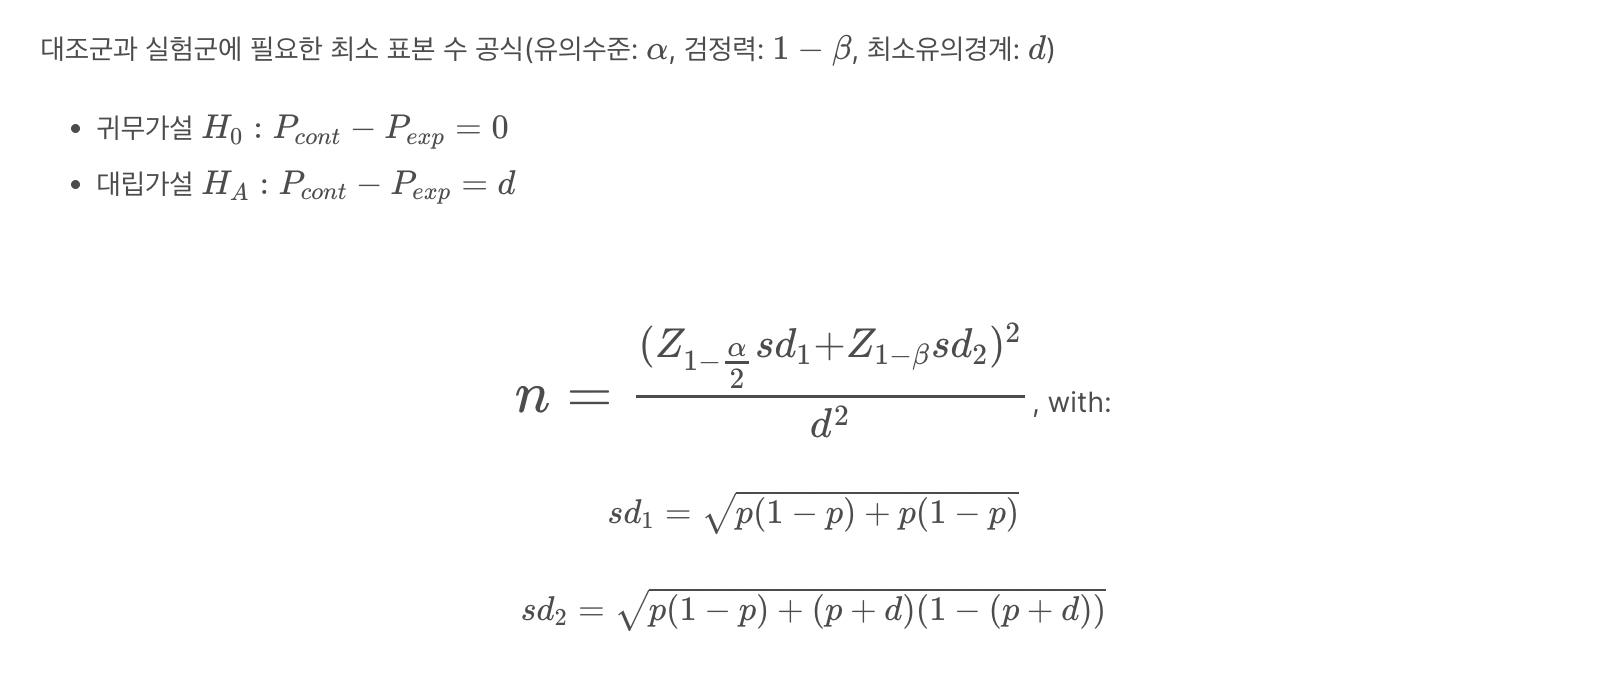

In [18]:
# scipy.stats.norm.ppf()를 이용하여 z score를 구하는 함수를 만든다.
def get_z_score(number):
    return norm.ppf(number)

# 기존에 문제에서 주어진  𝑝̂  와  𝑑 를 이용하여 standard deviation 1 & 2 를 구한다.
def get_sds(p,d):
    sd1=mt.sqrt(2*p*(1-p))
    sd2=mt.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

# 1과 2를 이용하여 적정한 표본 수를 공식에 맞춰 구한다.
def get_sampSize(sds,alpha,beta,d):
    n=pow((get_z_score(1-alpha/2)*sds[0]+get_z_score(1-beta)*sds[1]),2)/pow(d,2)
    return n

In [19]:
#GConversion : 클릭>등록 전환율 Samplesize
sds_GC = get_sds(GC['p'], GC['d'])
GC["SampSize"]=round(get_sampSize(sds_GC, alpha, beta, GC["d"])) #GC에 필요한 실험군 숫자
GC["SampSize"]=round(GC["SampSize"]*2 / baseline['CTP']) #실험군+대조군을 합해서 필요한 수업 상세페이지 진입 숫자
GC["SampSize"]

645875

In [20]:
#일일 수업 상세페이지 진입 수는 40,000 임으로 GC Samplesize에 필요한 실험일자는 16일
GC["SampSize"]/40000

16.146875

In [21]:
#Retention : 등록>결제 전환율 Samplesize에 따른 실험일자 118일(헐?)
sds_R = get_sds(R['p'], R['d'])
R["SampSize"]=round(get_sampSize(sds_R, alpha, beta, R["d"]))
R["SampSize"]=round(R["SampSize"]*2/0.0165)
R["SampSize"]/40000

118.44545

In [22]:
#NConversion : 필요 실험일자 17일
sds_NC = get_sds(NC['p'], NC['d'])
NC["SampSize"]=round(get_sampSize(sds_NC, alpha, beta, NC["d"]))
NC["SampSize"] = round(NC["SampSize"]/0.08*2)
NC["SampSize"]/40000

17.133125

In [23]:
GC["SampSize"] , R["SampSize"], NC["SampSize"]

(645875, 4737818, 685325)

# 2. Analyzing
## 2.1. Sanity Check

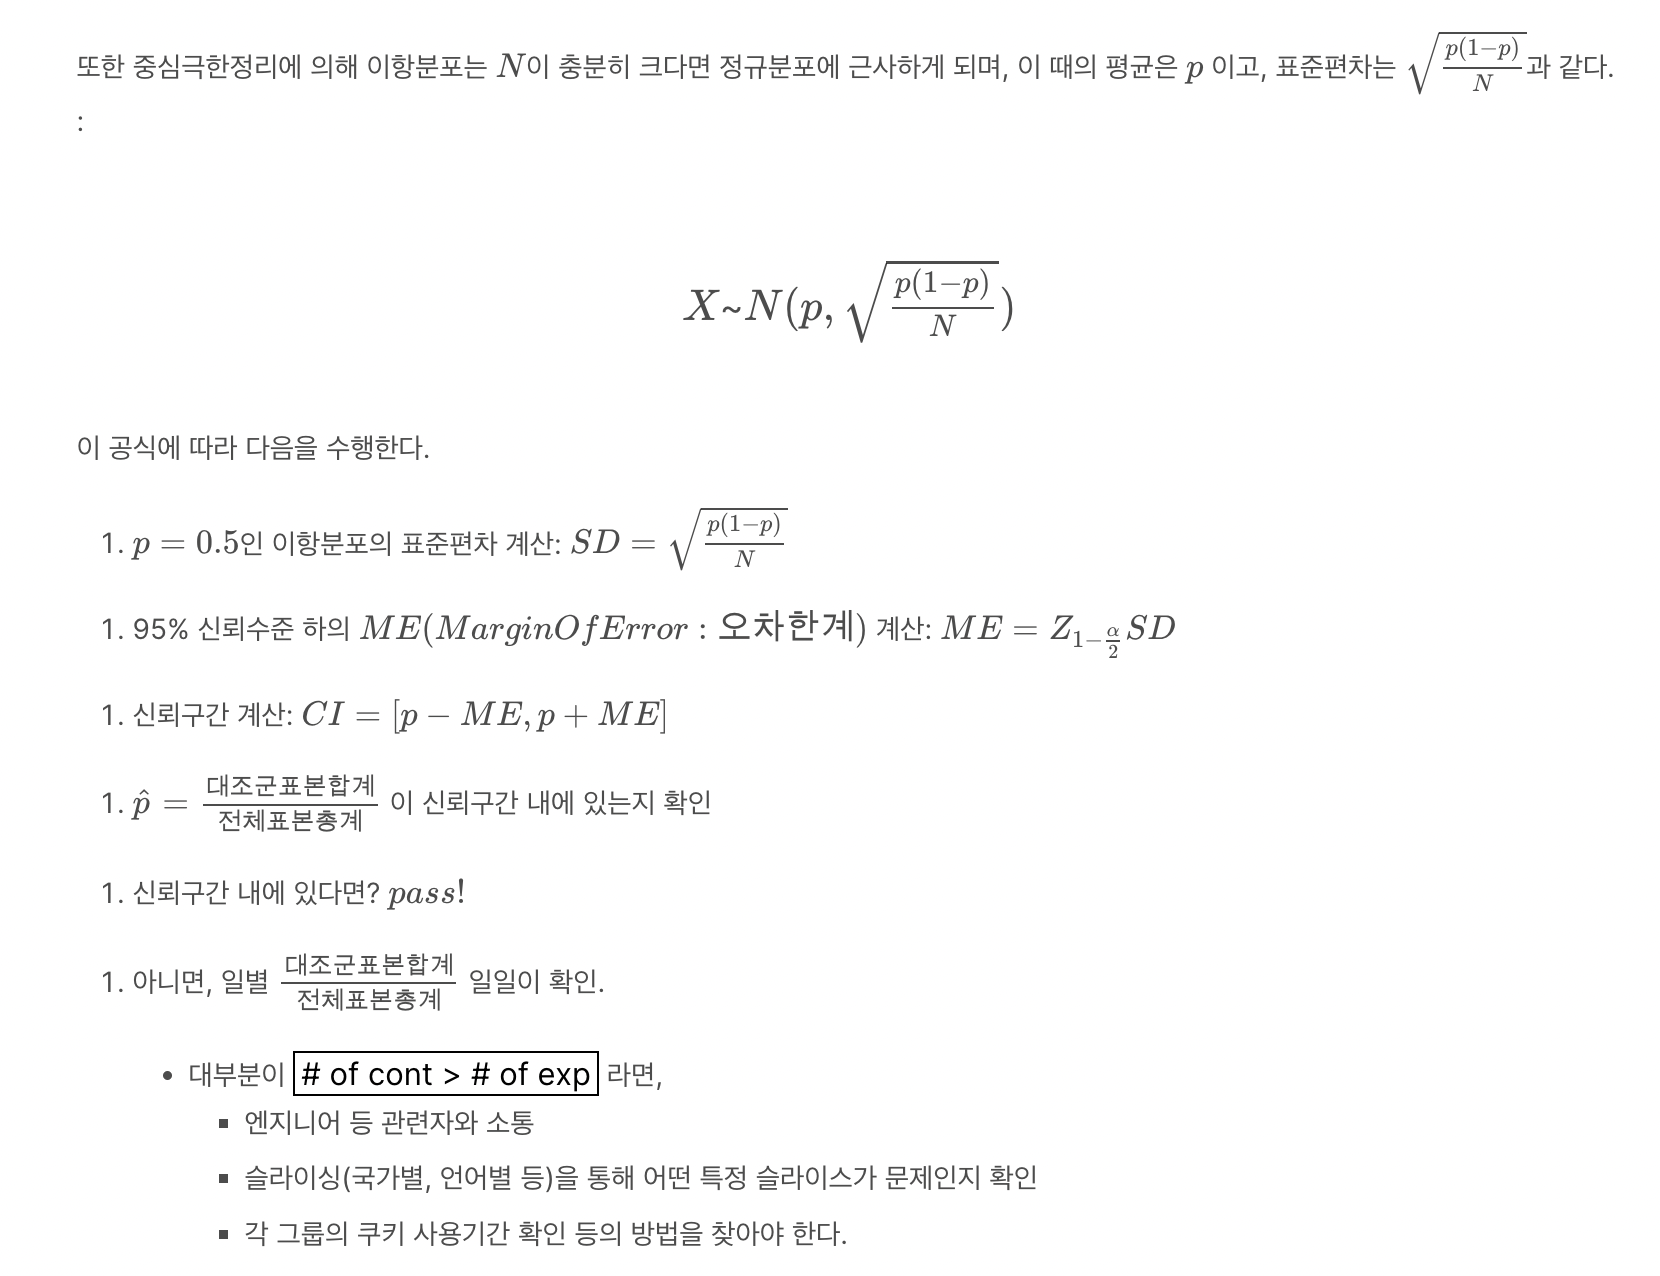

In [24]:
# 개별 그룹의 페이지 뷰 합계 및 합친 총계를 할당
clicks_cont = control['Clicks'].sum()
clicks_exp = exp['Clicks'].sum()
clicks_total = clicks_cont + clicks_exp

print ("대조군의 클릭 수:", clicks_cont)
print ("실험군의 클릭 수:", clicks_exp)

대조군의 클릭 수: 28378
실험군의 클릭 수: 28325


In [25]:
# 표준편차 계산
p = 0.5
sd = mt.sqrt(p*(1-p)/(clicks_total))

# 95% 신뢰수준 하의 ME 계산
alpha = 0.05
ME = round(get_z_score(1-(alpha/2))*sd,4)

# 신뢰구간 계산
upper_bound = p + ME
lower_bound = p - ME

# 신뢰구간 내에 p_hat이 있는지 확인
p_hat = round(clicks_cont/(clicks_total),4)

if (p_hat >= lower_bound) | (p_hat <= upper_bound):
    print("Sanity check passed!")

else:
    print("Need to check further..")

print("신뢰구간: ",lower_bound,"~",upper_bound)
print("p-hat: ", p_hat)

Sanity check passed!
신뢰구간:  0.4959 ~ 0.5041
p-hat:  0.5005


## 2.2. Effect Size

In [26]:

# purchase는 14일 이후 기록되기 때문에 최근 14일 값은 제외한다
clicks_cont = control["Clicks"].loc[control["Enrollments"].notnull()].sum()
clicks_exp = exp["Clicks"].loc[exp["Enrollments"].notnull()].sum()
enrollments_cont = control["Enrollments"].sum()
enrollments_exp = exp["Enrollments"].sum()

# 각 그룹의 GC 계산
GC_cont = enrollments_cont/clicks_cont
GC_exp = enrollments_exp/clicks_exp

# 합동 GC 계산. 이를 이용하여 합동 SD계산
GC_pooled = (enrollments_cont+enrollments_exp) / (clicks_cont+clicks_exp)
GC_sd_pooled = mt.sqrt(GC_pooled*(1-GC_pooled) * (1/clicks_cont + 1/clicks_exp))

# 합동SD이용하여 GC의 오차한계(ME) 계산
GC_ME = round(get_z_score(1-alpha/2) * GC_sd_pooled, 4)

# 실험군 대조군 GC 차이 계산
GC_diff = round(GC_exp - GC_cont, 4)

# 신뢰구간 계산
upper_bound = GC_diff + GC_ME
lower_bound = GC_diff - GC_ME

print("The change due to the experiment is",GC_diff*100,"%")
print("Confidence Interval: [",lower_bound,",",upper_bound,"]")
print ("The change is statistically significant if the CI doesn't include 0. \
In that case, it is practically significant if",-GC["d_min"],"is not in the CI as well.")

The change due to the experiment is -2.06 %
Confidence Interval: [ -0.0292 , -0.012 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if -0.01 is not in the CI as well.


In [27]:
payments_cont = control["Payments"].sum()
payments_exp = exp["Payments"].sum()

# 각 그룹의 Net Conversion 계산
NC_cont = payments_cont / clicks_cont
NC_exp = payments_exp / clicks_exp

# 합동NC 계산 및 이를 이용한 합동 표준오차 계산
NC_pooled = (payments_cont+payments_exp) / (clicks_cont+clicks_exp)
NC_sd_pooled = mt.sqrt(NC_pooled*(1-NC_pooled) * (1/clicks_cont+1/clicks_exp))

# 오차한계(ME)계산
NC_ME = round(get_z_score(1-alpha/2) * NC_sd_pooled,4)

# 실험군과 대조군 NC 차이 계산
NC_diff = round(NC_exp-NC_cont,4)

# 신뢰구간 계산
upper_bound = round(NC_diff + NC_ME, 4)
lower_bound = NC_diff - NC_ME

print("The change due to the experiment is",NC_diff*100,"%")
print("Confidence Interval: [",lower_bound,",",upper_bound,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",
       -NC["d_min"],"is not in the CI as well.")

The change due to the experiment is -0.49 %
Confidence Interval: [ -0.0116 , 0.0018 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if -0.0075 is not in the CI as well.


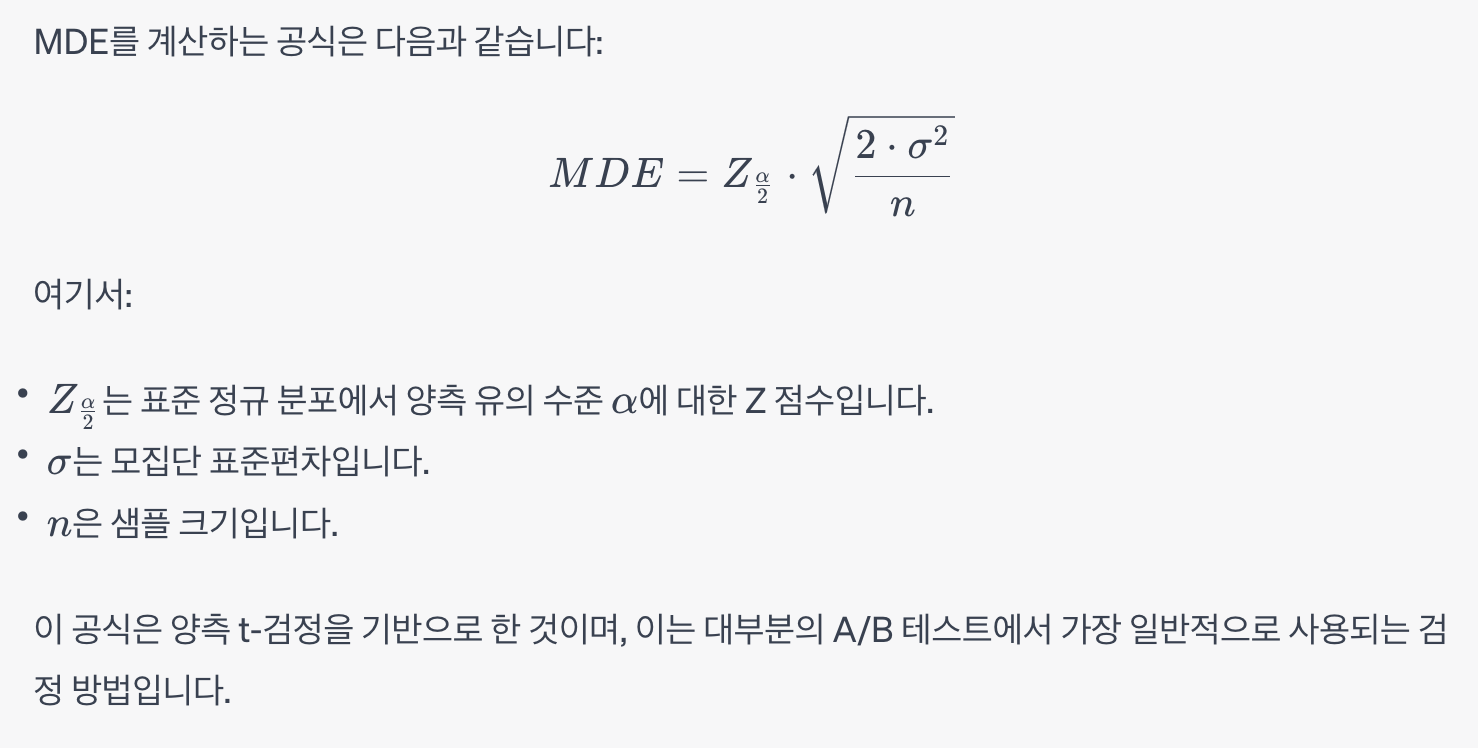

In [38]:
control = control.dropna()
exp = exp.dropna()

In [40]:
#mde 구하기
alpha = 0.05 # significance level
power = 0.8 # desired power of the test
sigma = control['Enrollments'].std() # standard deviation of the population
n = len(control['Enrollments']) # sample size

# Calculate the z-score for the given alpha
z_alpha = stats.norm.ppf(1-alpha/2)

# Calculate the MDE
dmin_enroll = z_alpha * np.sqrt(2 * (sigma**2) / n)
dmin_enroll

17.325562544755233

In [41]:
sigma = control['Payments'].std() # standard deviation of the population
n = len(control['Payments']) # sample size

# Calculate the z-score for the given alpha
z_alpha = stats.norm.ppf(1-alpha/2)

# Calculate the MDE
dmin_pay = z_alpha * np.sqrt(2 * (sigma**2) / n)
dmin_pay

11.935028727934872

In [45]:
mean_diff_enroll = exp['Enrollments'].mean() - control['Enrollments'].mean()
mean_diff_pay = exp['Payments'].mean() - control['Payments'].mean()

# se계산
sem_enroll = stats.sem(exp['Enrollments'] - control['Enrollments'])
sem_pay = stats.sem(exp['Payments'] - control['Payments'])

# 신뢰구간
conf_interval_enroll = stats.t.interval(0.95, len(control['Enrollments'])-1,
                                        loc=mean_diff_enroll,
                                        scale=sem_enroll)
conf_interval_pay = stats.t.interval(0.95, len(control['Payments'])-1,
                                     loc=mean_diff_pay,
                                     scale=sem_pay)

# Print confidence intervals
conf_interval_enroll, conf_interval_pay

((-24.21927496836458, -7.258985901200612),
 (-14.004882095331755, 6.352708182288257))

In [44]:
increase_enroll = (exp['Enrollments'].mean() - control['Enrollments'].mean()) / control['Enrollments'].mean() * 100
increase_pay = (exp['Payments'].mean() - control['Payments'].mean()) / control['Payments'].mean() * 100

increase_enroll, increase_pay

(-9.564068692206067, -4.328578455484516)